In [21]:
import pickle
import turtle

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from IPython.display import Image
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
from scipy.integrate import solve_ivp
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import Ridge
from sklearn.linear_model import OrthogonalMatchingPursuit
from sklearn.linear_model import Lars
from sklearn.linear_model import LassoLars

from pysindy.utils import lorenz, lorenz_control, enzyme
import pysindy as ps

# bad code but allows us to ignore warnings
import warnings
from scipy.integrate.odepack import ODEintWarning
warnings.simplefilter("ignore", category=UserWarning)
warnings.simplefilter("ignore", category=FutureWarning)
warnings.simplefilter("ignore", category=ODEintWarning)
warnings.filterwarnings("ignore", category=UserWarning)
import scipy.io as spio
import math
import pickle
import os
from numpy import diff
import pykoopman as pk
from numpy import diff
from sklearn.metrics import mean_squared_error
import sys
# sys.path.append('D:\\Koopman_F1tenth\\Ajinkya_koopman_deployments\\F1tenth_utils')
# print(sys.path)
# sys.path.remove('D:\\Koopman_F1tenth\\Ajinkya_koopman_deployments\\utils')
from F1tenth_utils import data_preprocess_spline as dp
from F1tenth_utils import plotter_tools
from F1tenth_utils import lift_states
from F1tenth_utils import plotter_tools_ol
from F1tenth_utils import plotter_tools_data_processed
import importlib
importlib.reload(dp)
importlib.reload(plotter_tools)
importlib.reload(plotter_tools_ol)
importlib.reload(lift_states)




C:\Users\ajoglek\AppData\Local\Temp\ipykernel_8408\4190041140.py:24: DeprecationWarning: Please use `ODEintWarning` from the `scipy.integrate` namespace, the `scipy.integrate.odepack` namespace is deprecated.
  from scipy.integrate.odepack import ODEintWarning


<module 'F1tenth_utils.lift_states' from 'D:\\Koopman_F1tenth\\Ajinkya_koopman_deployments\\F1tenth_utils\\lift_states.py'>

In [2]:
# Call the utils function for data pre-processing
X_train, X_orig, Y_train, U_train, U_orig, T_diff_states,T_diff_inputs,f_name = dp.preprocess('D:\Koopman_F1tenth\Ajinkya_koopman_deployments\Data_Calib_Filter\\Train_fishhook_cw_ccw')
X_test, X_test_orig, Y_test, U_test, U_test_orig,T_diff_states_test,T_diff_inputs_test,f_name_test = dp.preprocess('D:\Koopman_F1tenth\Ajinkya_koopman_deployments\Data_Calib_Filter\\Test')


In [22]:
#Save the filename lis, training and control data array
data_save_dir = './Matrices_saved/Data_fishhook_skidpad/'
X_train_dir = data_save_dir + 'X_train.npy'; U_train_dir = data_save_dir+'U_train.npy'; f_name_dir = data_save_dir + 'fname'
np.save(X_train_dir,np.array(X_train, dtype=object), allow_pickle=True)
np.save(U_train_dir,np.array(U_train, dtype=object), allow_pickle=True)
with open(f_name_dir, "wb") as f:
    pickle.dump(f_name,f)


In [27]:
# load test
with open(f_name_dir,'rb') as f:
    test = pickle.load(f)

print(test)
indices = [i for i, x in enumerate(test) if x == "fishhook_clean_v_1_5_filtered.mat"]
print(indices[0])

['fishhook_clean_v_0_5_filtered.mat', 'fishhook_clean_v_1_0_filtered.mat', 'fishhook_clean_v_1_5_filtered.mat', 'fishhook_clean_v_2_0_filtered.mat', 'fishhook_clean_v_2_5_filtered.mat', 'fishhook_cw_clean_v_0_5_filtered.mat', 'fishhook_cw_clean_v_1_0_filtered.mat', 'fishhook_cw_clean_v_1_5_filtered.mat', 'fishhook_cw_clean_v_2_0_filtered.mat', 'fishhook_cw_clean_v_2_5_filtered.mat', 'skidpad_clean_v_0_5_d_0_312_filtered.mat', 'skidpad_clean_v_0_5_d_0_416_filtered.mat', 'skidpad_clean_v_0_5_d_0_520_filtered.mat', 'skidpad_clean_v_1_0_d_0_416_filtered.mat', 'skidpad_clean_v_1_5_d_0_312_filtered.mat', 'skidpad_clean_v_1_5_d_0_416_filtered.mat', 'skidpad_clean_v_1_5_d_0_520_filtered.mat', 'skidpad_clean_v_2_0_d_0_312_filtered.mat', 'skidpad_cw_clean_v_0_5_d_0_312_filtered.mat', 'skidpad_cw_clean_v_0_5_d_0_416_filtered.mat', 'skidpad_cw_clean_v_1_0_d_0_312_filtered.mat', 'skidpad_cw_clean_v_1_5_d_0_520_filtered.mat', 'skidpad_cw_clean_v_2_5_d_0_520_filtered.mat']
2


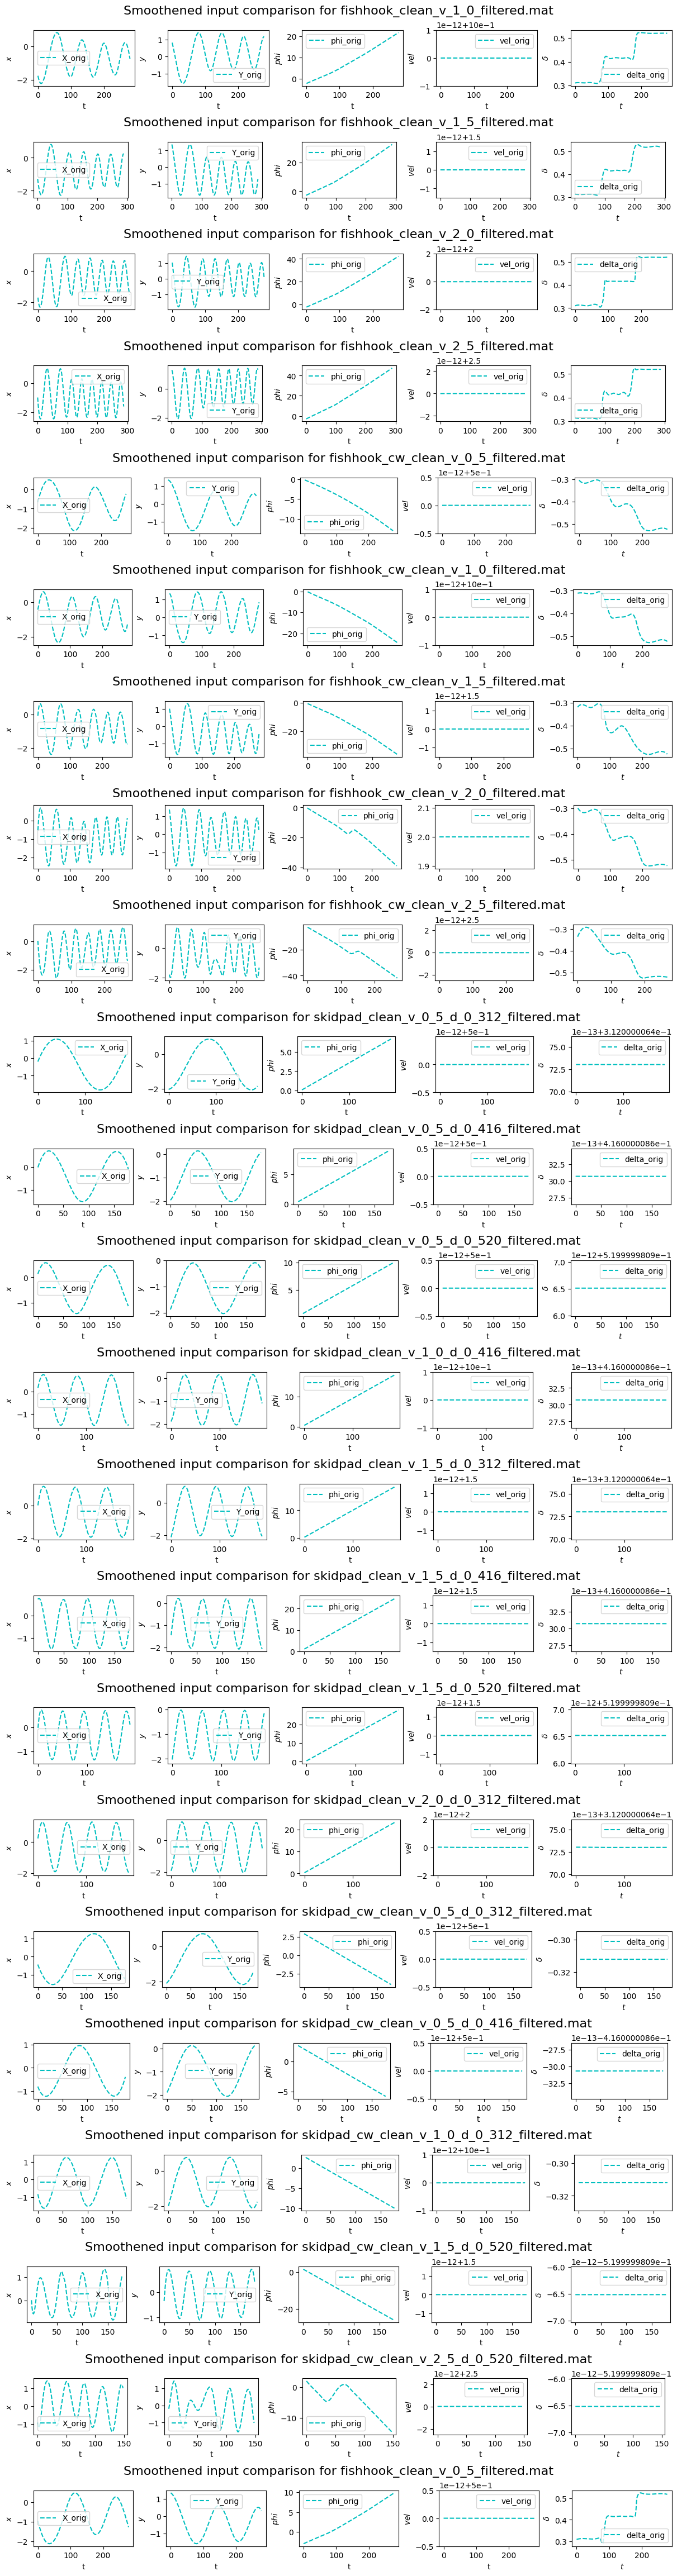

In [6]:
plotter_tools_data_processed.plot_processed_data(X_train,X_orig,U_train,U_orig,T_diff_states,T_diff_inputs,f_name)

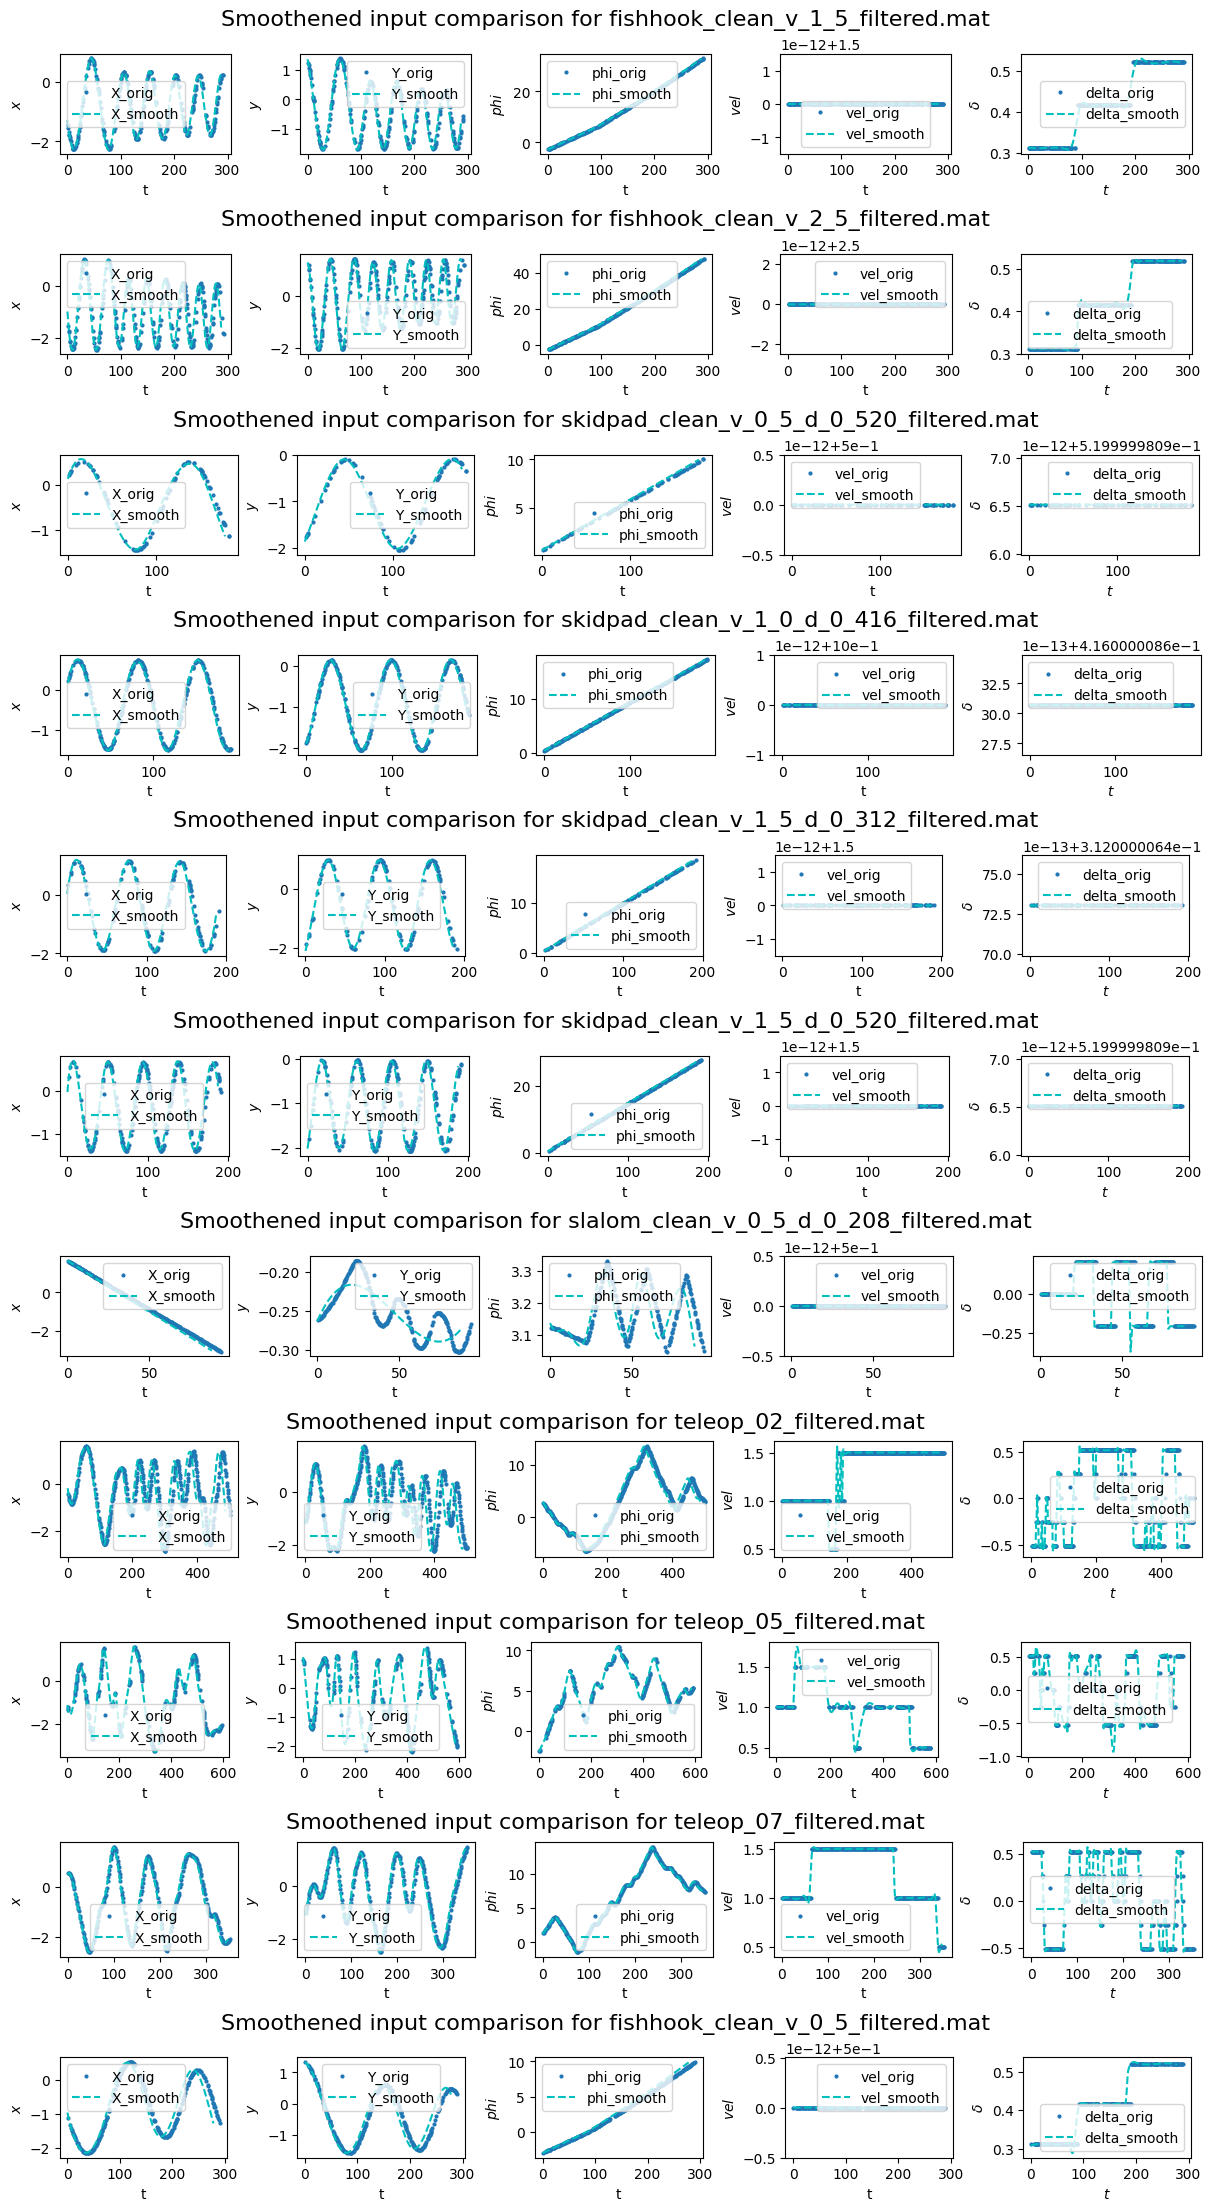

In [35]:
plotter_tools_data_processed.plot_processed_data(X_test,X_test_orig,U_test,U_test_orig,T_diff_states_test,T_diff_inputs_test,f_name_test)

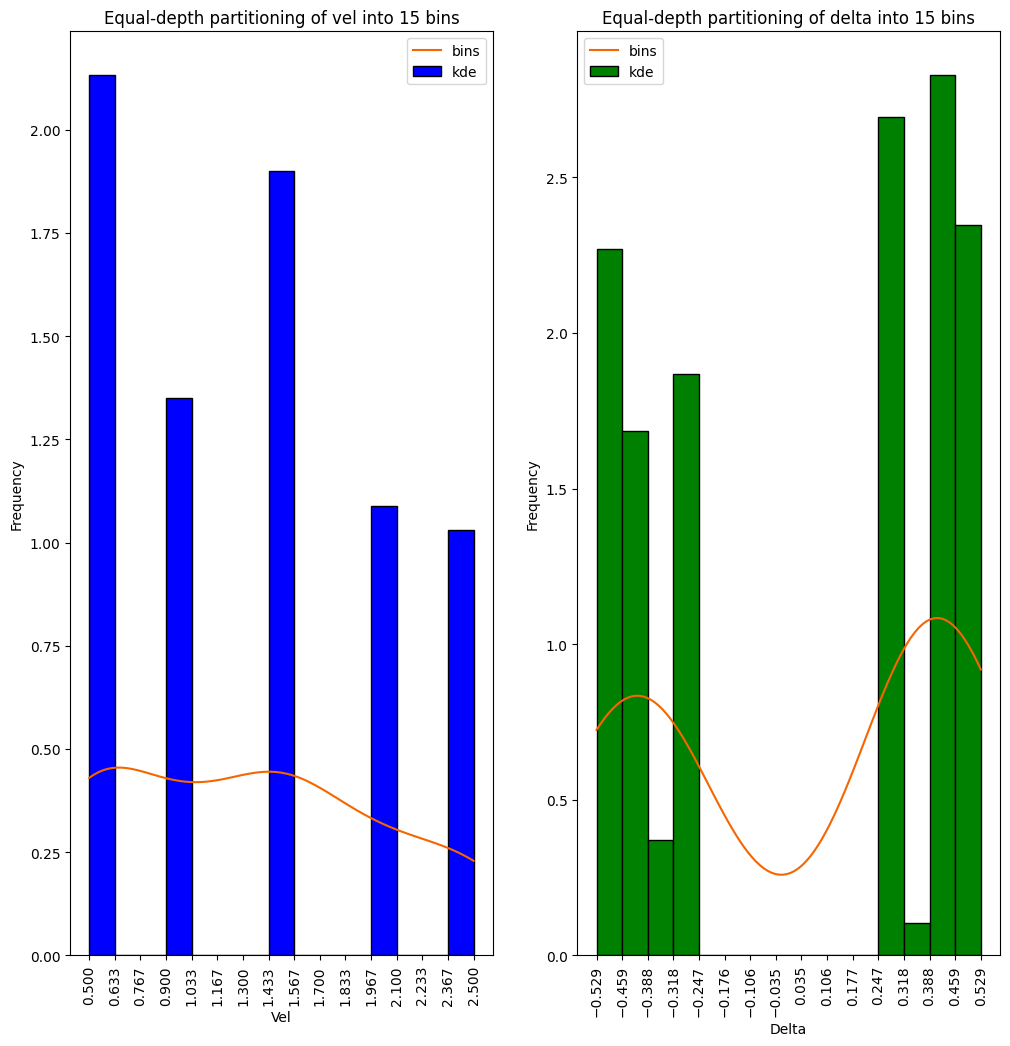

In [7]:
# Analyze the training data
from scipy.stats import gaussian_kde
X0 = np.vstack(X_train) # Vertical stack of data runs
# X0_norm = X0/X0.max(axis=0)
Y0 = np.vstack(Y_train)
# Y0_norm = Y0/Y0.max(axis=0)
U0 = np.vstack(U_train)

plt.figure(figsize=(12,12))
plt.subplot(1, 2, 1)
n, bins, patches = plt.hist(U0[:,0], bins=15, density=True, facecolor='b', edgecolor='k')
density = gaussian_kde(U0[:,0])
xs = np.linspace(np.min(U0[:,0]), np.max(U0[:,0]), 100)
density.covariance_factor = lambda : .45
density._compute_covariance()
plt.plot(xs, density(xs), color="#f56600", label="Density")
plt.xlabel('Vel')
plt.ylabel('Frequency')
plt.legend(['bins','kde'])
plt.title('Equal-depth partitioning of vel into 15 bins')
plt.xticks(bins,rotation='vertical')

plt.subplot(1, 2, 2)
n, bins, patches = plt.hist(U0[:,1], bins=15, density=True, facecolor='g', edgecolor='k')
density = gaussian_kde(U0[:,1])
xs = np.linspace(np.min(U0[:,1]), np.max(U0[:,1]), 100)
density.covariance_factor = lambda : .45
density._compute_covariance()
plt.plot(xs, density(xs), color="#f56600", label="Density")
plt.xlabel('Delta')
plt.ylabel('Frequency')
plt.legend(['bins','kde'])
plt.title('Equal-depth partitioning of delta into 15 bins')
plt.xticks(bins,rotation='vertical')

plt.show()


In [8]:
def EDMD_koopman(X0,Y0,U):
    X0 = np.vstack(X0) # Vertical stack of data runs
    # X0_norm = X0/X0.max(axis=0)
    Y0 = np.vstack(Y0)
    # Y0_norm = Y0/Y0.max(axis=0)
    U0 = np.vstack(U)
    # U0_norm = U0/U0.max(axis=0)
    print(X0.shape,Y0.shape,U0.shape)

    # Lifting of states
    X_lift = lift_states.lift_states(X0)
    # X_normed = X_lift / X_lift.max(axis=1)
    Y_lift = lift_states.lift_states(Y0)
    # Y_normed = Y_lift/Y_lift.max(axis=1)
    # print(X_lift.shape,Y_lift.shape,U0.shape)
    zt = X_lift
    zt_plus1 = Y_lift
    zt_control = np.row_stack((X_lift,U0.T)) # Stacking for left shifted control matrix
    print('Array shapes of zt, zt+1 and zt_control are',zt.shape,zt_plus1.shape,zt_control.shape)

    # Koopman A and B matrix by EDMD
    A_B = zt_plus1@zt_control.T@np.linalg.pinv(zt_control@zt_control.T) # Analytical solution for data snapshots
    A_edmd = np.round(A_B[:,:-2],4) # Get A matrix baring the last two columns for control matrix rounded
    B_edmd = np.round(A_B[:,-2:],4) # Get B matrix with the last two columns for control matrix rounded
    print(np.linalg.pinv(zt).shape)
    C_edmd =  np.round(X0.T@np.linalg.pinv(zt))
    return A_B,A_edmd,B_edmd, C_edmd

In [9]:
# Lift the system analytically to get A,B,C matrix from X_train data
from numpy import linalg as LA
AB, A_edmd, B_edmd, Cedmd =  EDMD_koopman(X_train,Y_train,U_train)
# print(Cedmd)
w, v = LA.eig(A_edmd)
print(AB.shape,A_edmd.shape,B_edmd.shape)

(5147, 4) (5147, 4) (5147, 2)
Array shapes of zt, zt+1 and zt_control are (12, 5147) (12, 5147) (14, 5147)
(5147, 12)
(12, 14) (12, 12) (12, 2)


In [10]:
#Optimization tryouts for the AB matrix using EDMD lifting
# Import packages.
import cvxpy as cp
import numpy as np
from cvxpy.atoms.norm import norm

# Generate data.

X0 = np.vstack(X_train)
Y0 = np.vstack(Y_train)
U0 = np.vstack(U_train).T
X_t = lift_states.lift_states(X0)
Y_t = lift_states.lift_states(Y0)


# Define and solve the CVXPY problem.
A_edmd_fro = cp.Variable((X_t.shape[0],X_t.shape[0]))
B_edmd_fro = cp.Variable((X_t.shape[0],2))
cost_in_fro = norm((Y_t - A_edmd_fro @ X_t -B_edmd_fro @ U0),'fro')**2
# cost = norm(Y_opt - A @ X_opt -B @ U0)
prob = cp.Problem(cp.Minimize(cost_in_fro))
prob.solve(solver=cp.SCS,verbose=True)

# print(A_edmd_fro.value)

A_edmd_fro = np.array(A_edmd_fro.value)
B_edmd_fro = np.array(B_edmd_fro.value)

if A_edmd.all() == A_edmd_fro.all():
    print('WTF')
# # Print result.
# print("\nThe optimal value is", prob.value)
# print("The optimal x is")
# print(A.value,B.value)
print(A_edmd_fro.shape,B_edmd_fro.shape)

                                     CVXPY                                     
                                     v1.3.0                                    
(CVXPY) Feb 21 11:34:49 AM: Your problem has 168 variables, 0 constraints, and 0 parameters.
(CVXPY) Feb 21 11:34:49 AM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Feb 21 11:34:49 AM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Feb 21 11:34:49 AM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Feb 21 11:34:49 AM: Compiling problem (target solver=SCS).
(CVXPY) Feb 21 11:34:49 AM: Reduction chain: Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuffing ->

In [52]:
# Save the A,B,C matrix
# fname_A_edmd_fro = './Matrices_saved/A_EDMD_fro';fname_B_edmd_fro = './Matrices_saved/B_EDMD_fro';fname_C_edmd_fro = './Matrices_saved/C_EDMD_fro'
# np.save(fname_A_edmd_fro, A_edmd_fro)
# np.save(fname_B_edmd_fro,B_edmd_fro)
# np.save(fname_C_edmd_fro,Cedmd)

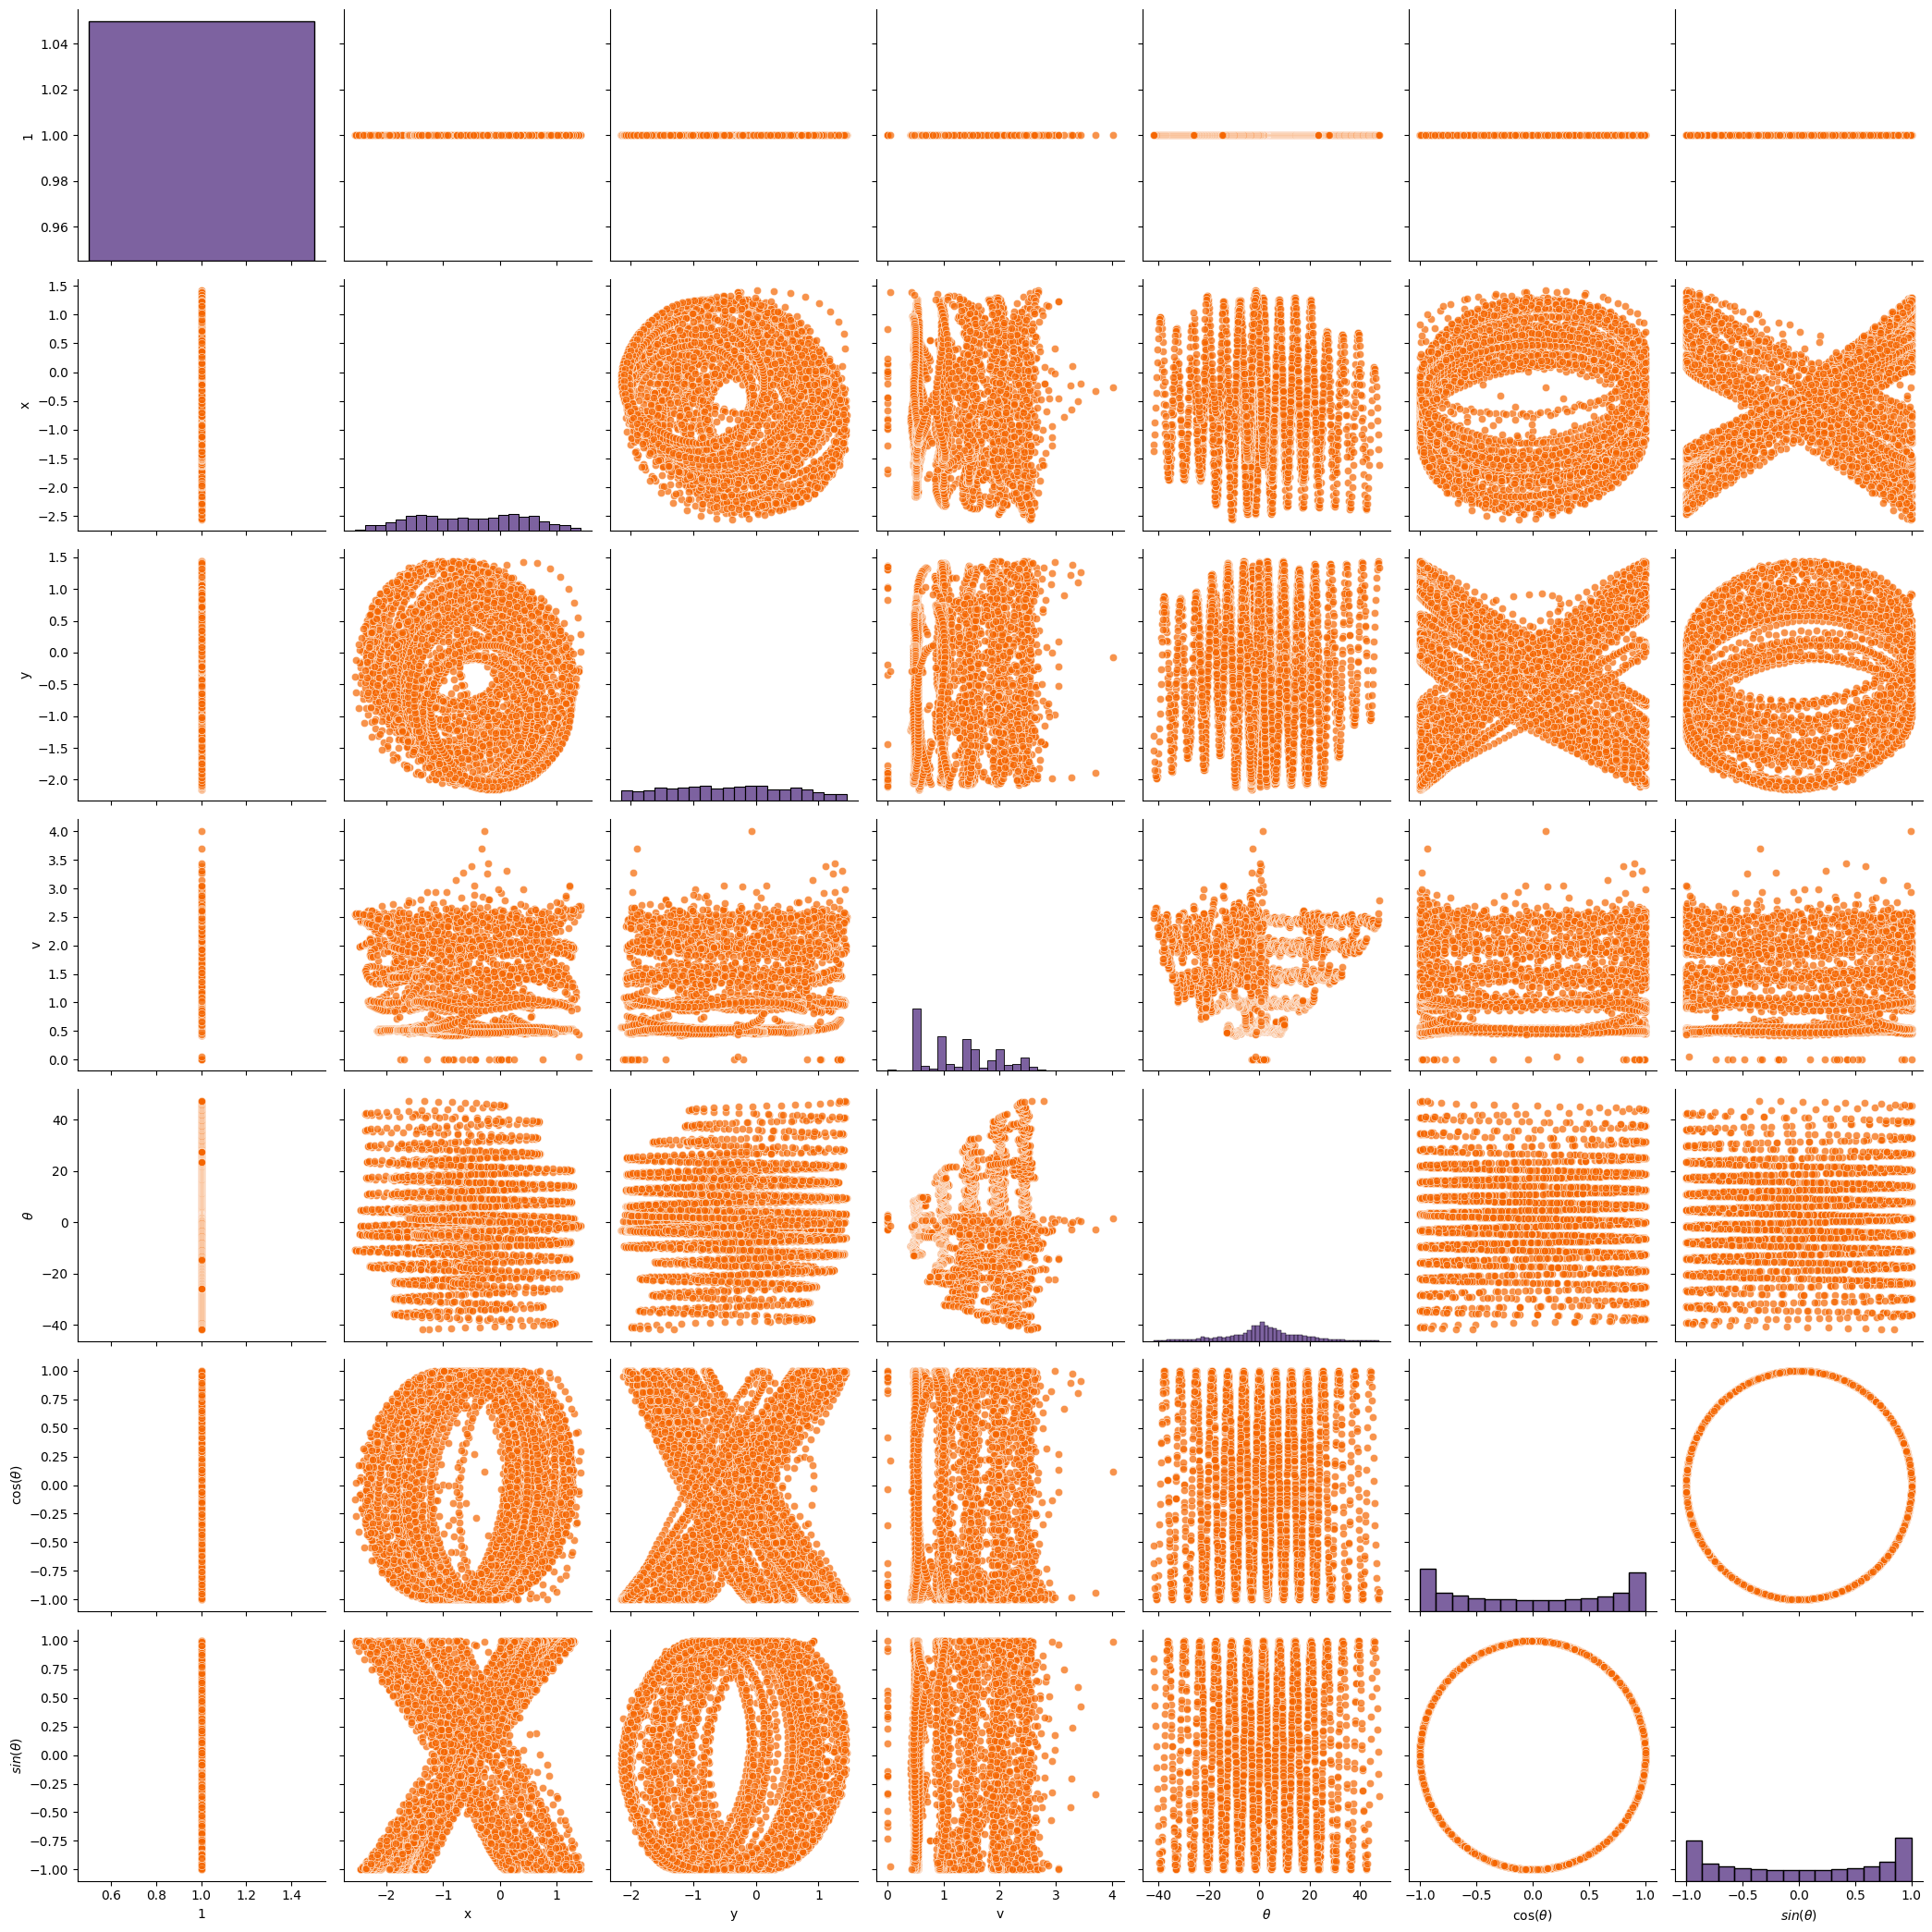

In [11]:
# Plot the relation between the lifted states
import seaborn as sns
import pandas as pd
df = pd.DataFrame(X_t[:7,:].T, columns = ['1','x','y','v',r'$\theta$',r'$\cos(\theta)$',r'$sin(\theta)$'])
sns.pairplot(data=df, height=3,
             plot_kws={"color": "#f56600", "alpha": 0.7},
             diag_kws={"color": "#522d80"})
plt.tight_layout()
plt.show()

Figure name not provided for save file


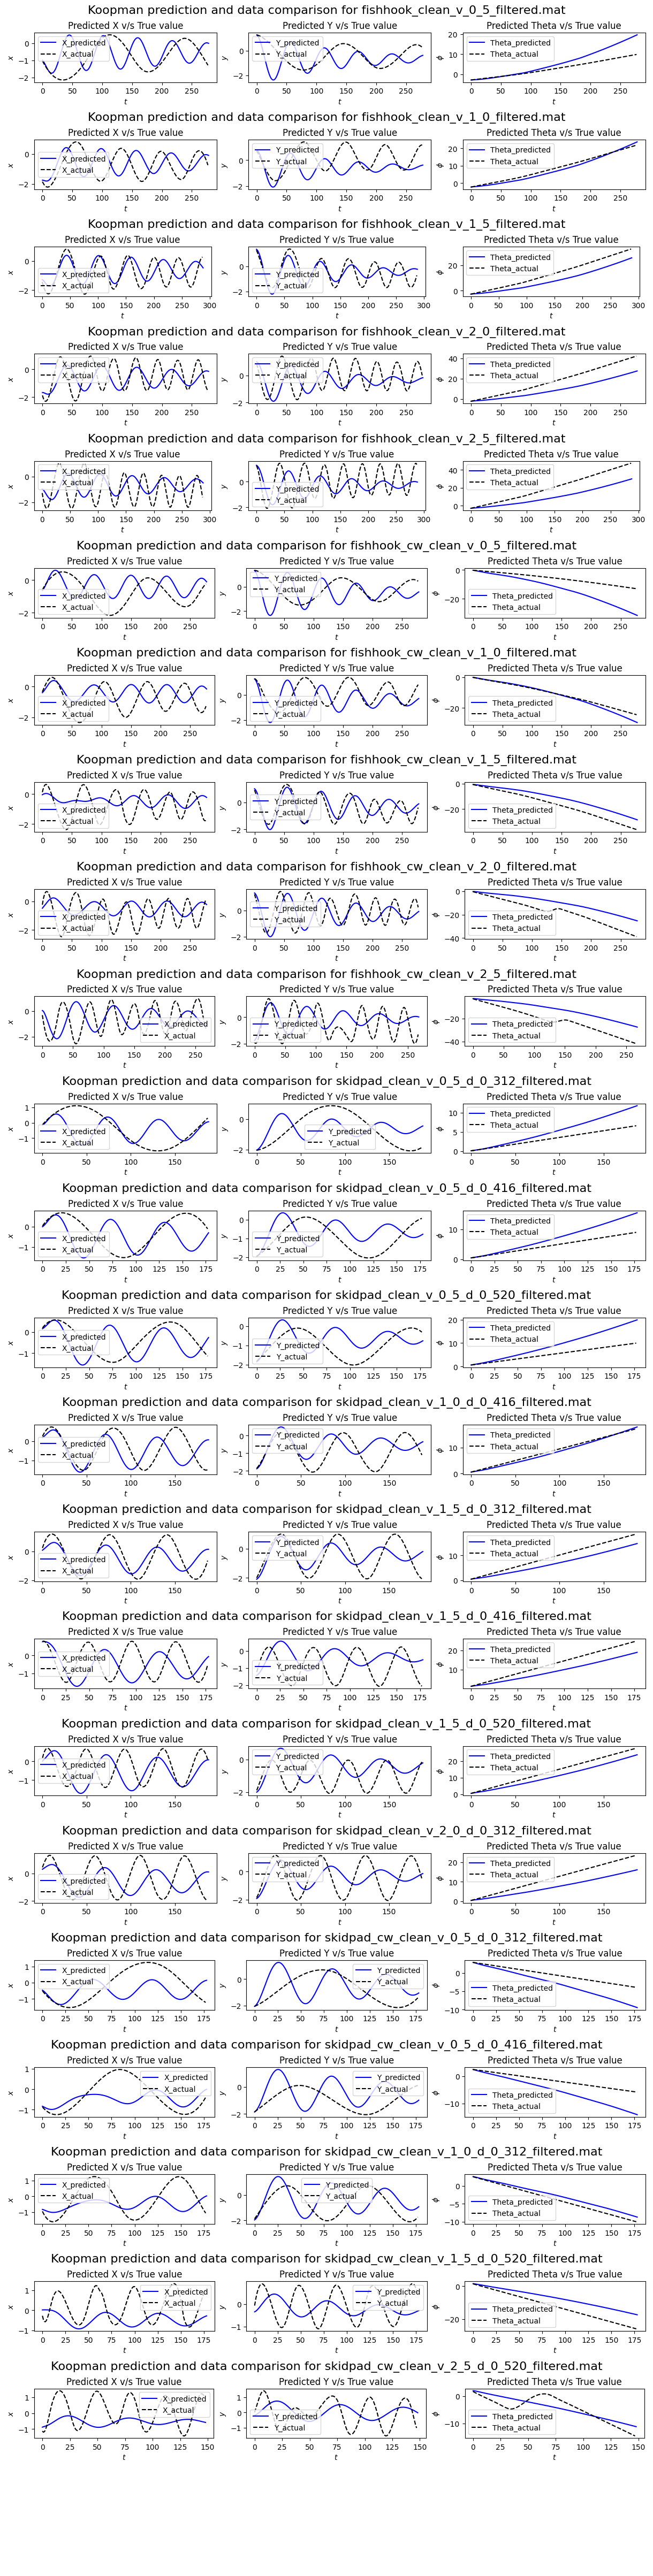

In [12]:
run_name = f_name
imsave_name = 'Koopman_edmd_training_prediction_ol_skidpad_teleop'
plotter_tools_ol.plot_lifted_predictions(X_train,A_edmd_fro,B_edmd_fro,U_train,run_name)

Figure name not provided for save file


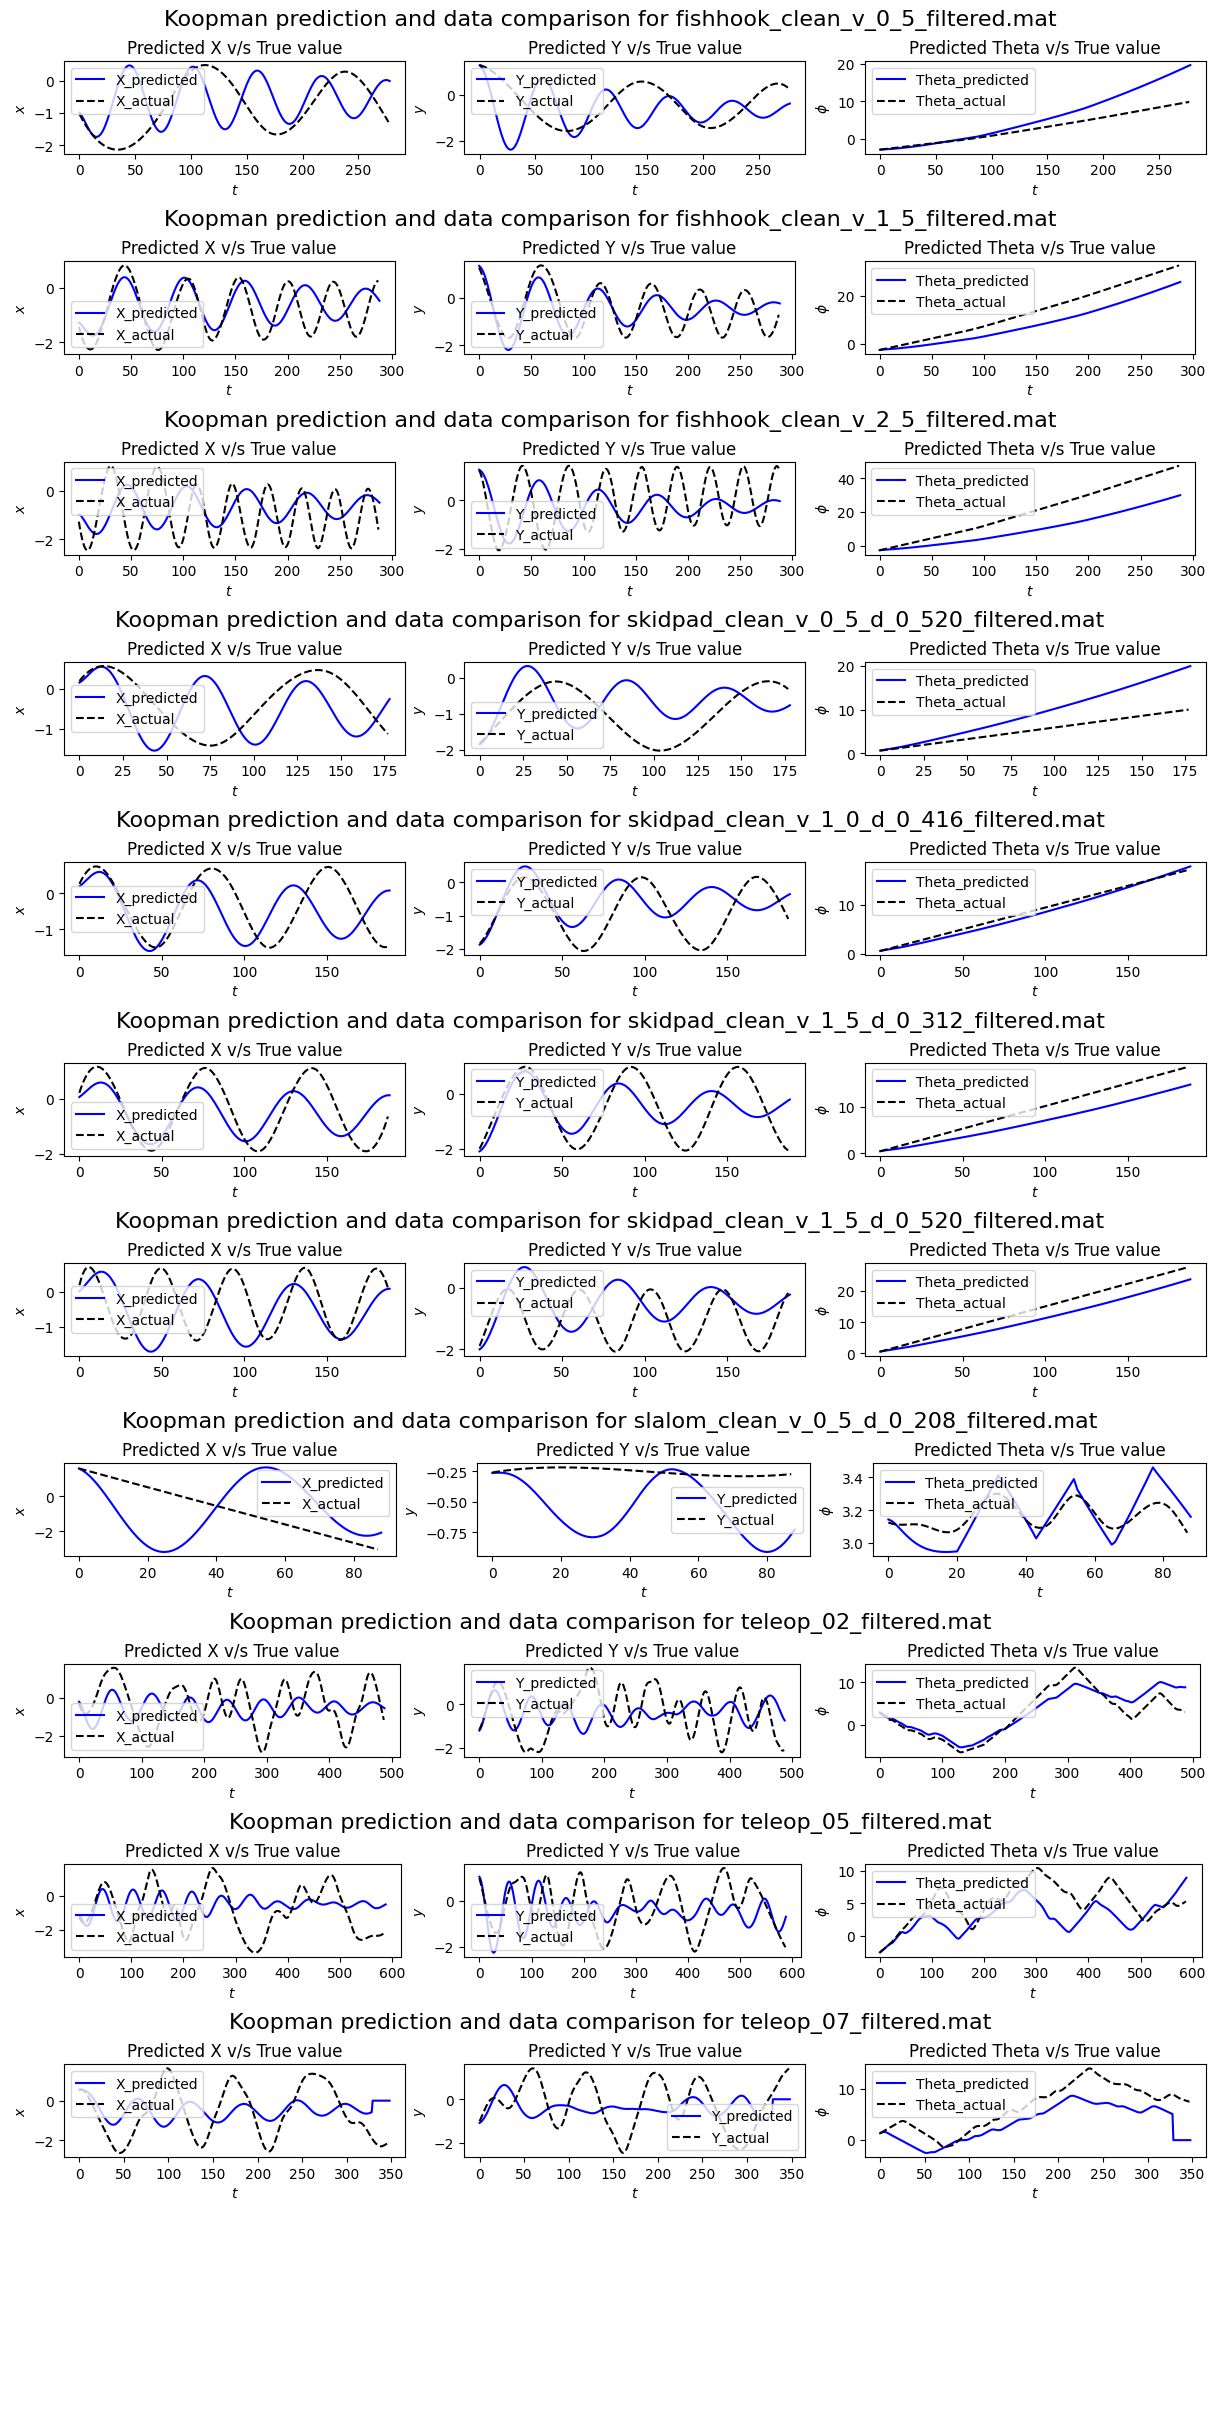

In [13]:
run_name = f_name_test
imsave_name = 'Koopman_edmd_test_prediction_ol_skidpad_teleop'
# print(X_test[5].shape)
plotter_tools_ol.plot_lifted_predictions(X_test,A_edmd_fro,B_edmd_fro,U_test,run_name)


In [14]:

def simulate_ol(A,B,C,X,u):
    zt = lift_states.lift_states(X) # Lifting the data in x
    z_prime = np.zeros((zt.shape[0],zt.shape[1]))
    u = u.T
    # z_prime[:,0] = zt[:,0]
    # print(A.shape,B.shape,X.shape,u.shape)
    z_prime[:,0] = A@zt[:,0] + B@u[:,0] #This is like the first value of Y array with 1st value of X and U
    for i in range(1,u.shape[1]):
            z_prime[:,i] = A@z_prime[:,i-1] + B@u[:,i] # Because X and U are one timestep behind Y, the U considered is ith iteration, also now we consider previous z_prime value

    x_hat_ = C@z_prime
    print(x_hat_.shape)
    return x_hat_

[1]


Loading...: 100%|██████████| 248/248 [01:07<00:00,  3.68it/s]


(4, 289)
(4, 289)


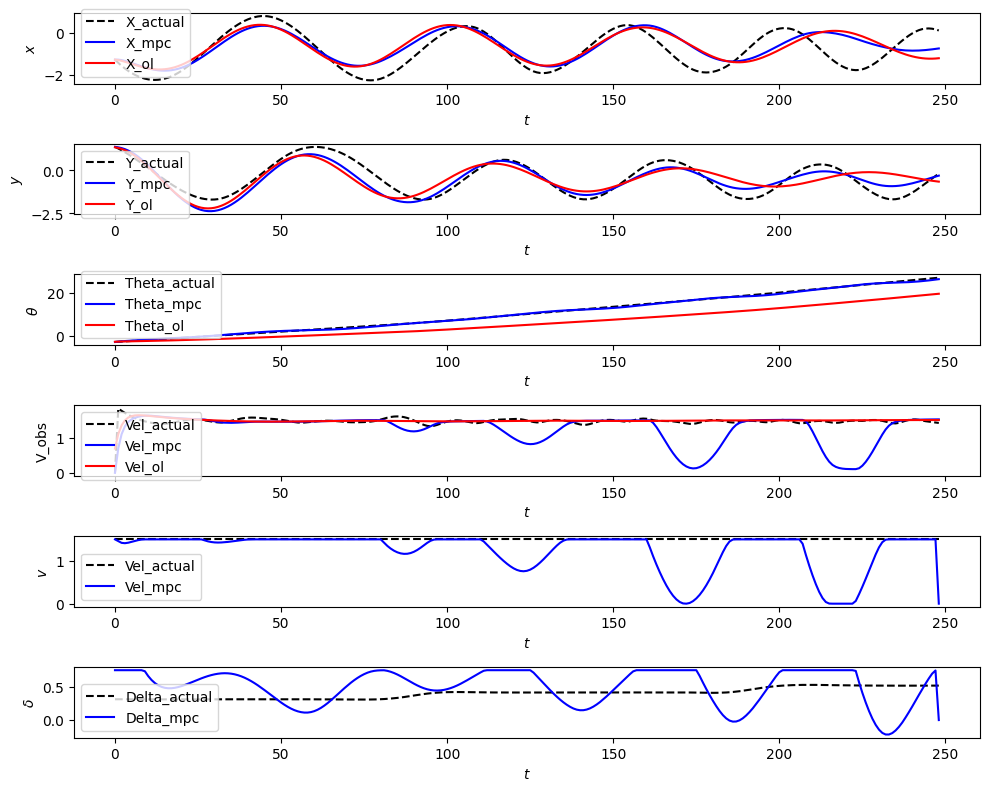

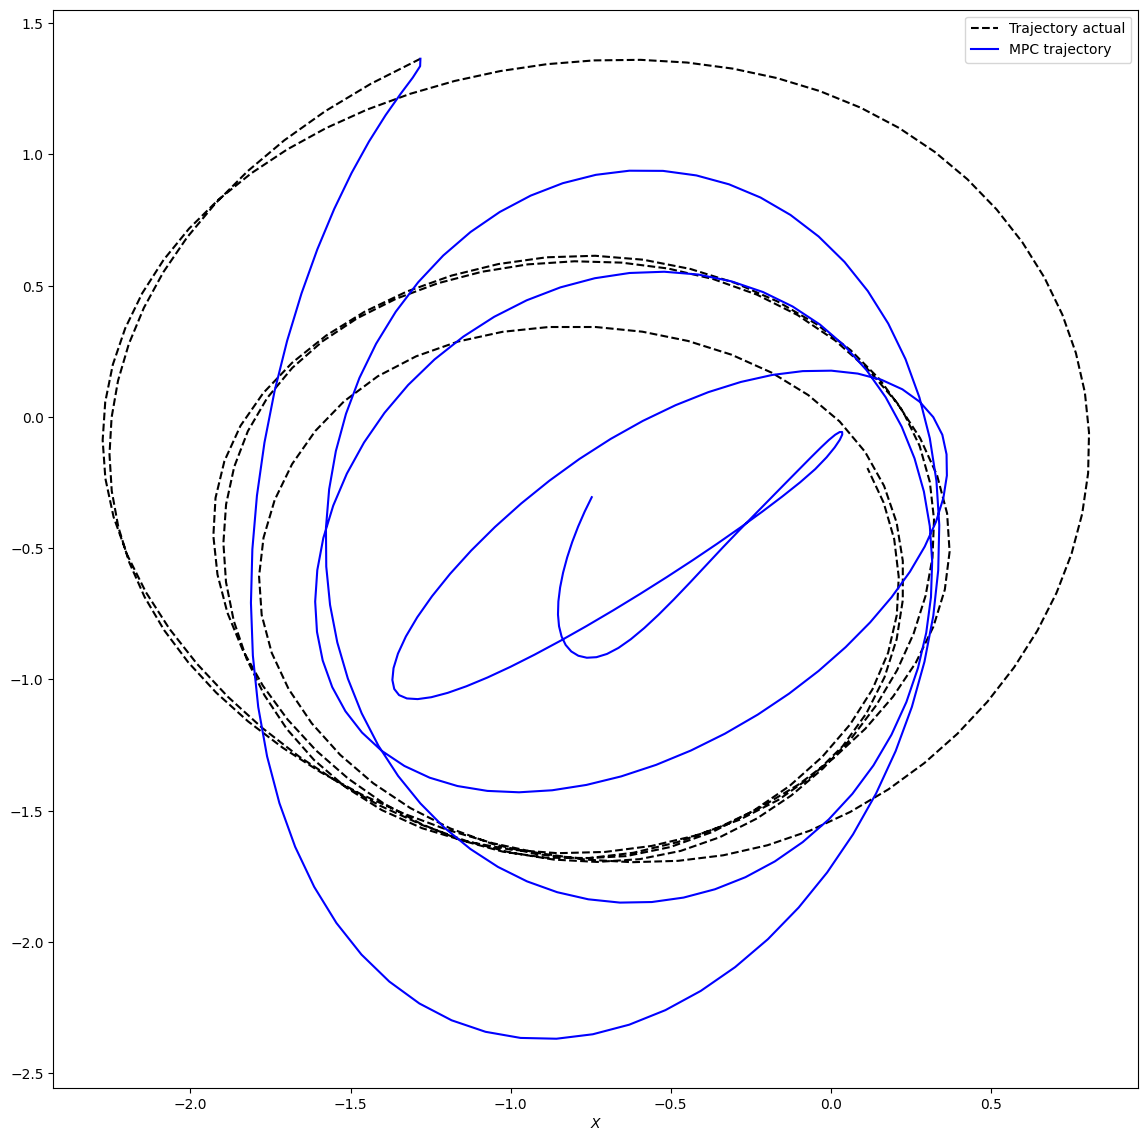

In [15]:
# Linear MPC with cvxpy
import cvxpy as cp
from cvxpy import reshape
from cvxopt import matrix
from tqdm import tqdm
import time
num = np.random.randint(0,len(X_test),1)
num = [1]
save_fig = 'No'
print(num)
# Initialization
x_ref = X_test[num[0]]
z_ref = lift_states.lift_states(x_ref)
u_ref = U_test[num[0]].T
N = 40 # Prediction horizon

z_init = np.zeros((z_ref.shape[0],z_ref.shape[1]))
z_init[:,0] = z_ref[:,0]

u_mpc = np.zeros((u_ref.shape[0],u_ref.shape[1]))


Q = np.zeros((z_ref.shape[0],z_ref.shape[0]))
R = np.eye(2)
Q[1,1] = 5; Q[2,2] = 5; Q[3,3] = 1; Q[4,4] = 1
umin = np.array([0,-0.75]).reshape(2)
umax = np.array([1.5,0.75]).reshape(2)
count = 1
time_count = []


for count in tqdm(range(1,z_ref.shape[1] - N),desc="Loading..."): # Main loop for solver
    z_pred = cp.Variable((z_ref.shape[0], N + 1))
    u_pred = cp.Variable((u_ref.shape[0], N))
    z_ref_ = matrix(z_ref[:,count:count+N+1]) # z_ref_ is the reference window for the current iteration of the loop
    u_ref_ = matrix(u_ref[:,count-1:count+N])
    # print(z_ref_.shpe,u_ref_.shape)
    cost = 0 # Initializing cost before the loop
    constr = [] # Initializing constaint value

    constr += [z_pred[:, 0] == z_init[:,count-1]]
    for i in range(N):
        # cost += cp.quad_form(reshape(z_pred[:,i+1],(z_ref.shape[0],1)) - z_ref_[:,i],Q)  # Quad prog required to do (x-x_ref).T@Q@(x-x_ref)
        # constr += [z_pred[:, i + 1] == A_edmd @ z_pred[:, i] + B_edmd @ u_pred[:, i],umin <=u_pred[:,i], u_pred[:,i]<= umax]
        if i == 0:
            cost += cp.quad_form(reshape(z_pred[:,i+1],(z_ref.shape[0],1)) - z_ref_[:,i],Q) # Quad prog required to do (x-x_ref).T@Q@(x-x_ref)
            constr += [z_pred[:, i + 1] == A_edmd @ z_pred[:, i] + B_edmd @ u_pred[:, i],umin <=u_pred[:,i], u_pred[:,i]<= umax]
        else:
            cost += cp.quad_form(reshape(z_pred[:,i+1],(z_ref.shape[0],1)) - z_ref_[:,i],Q) + cp.quad_form(reshape((u_pred[:,i]-u_pred[:,i-1])/0.5,(2,1)) ,np.eye(2)*5) # Quad prog required to do (x-x_ref).T@Q@(x-x_ref)
            constr += [z_pred[:, i + 1] == A_edmd @ z_pred[:, i] + B_edmd @ u_pred[:, i],umin <=u_pred[:,i], u_pred[:,i]<= umax]

    # constr += [z_pred[:, 0] == z_init[:,count-1]]
    problem = cp.Problem(cp.Minimize(cost), constr)
    problem.solve(solver=cp.OSQP,verbose=False)
    # print(problem.solve())
    u_mpc[:,count-1] = u_pred.value[:,0]
    z_init[:,count] = A_edmd@z_init[:,count-1] + B_edmd@u_pred.value[:,0]
    # z_init[:,count] = reshape(z_ref_[:,0],(15,1))
    # count += 1
    # t1 = time.time()
    # t_diff = t1-t0
    # time_count.append(t_diff)


# plt.plot(time_count)
# print(u_mpc.shape)
#Get open loop response
x_hat_ol = simulate_ol(A_edmd,B_edmd,Cedmd,X_test[num[0]],U_test[num[0]])
print(x_hat_ol.shape)

#Plot all
fig, axs = plt.subplots(6, 1, tight_layout=True, figsize=(10, 8))
# axs[0].plot(y[4,:], '--r')
axs[0].plot(X_test[num[0]][:-N,0],'--k', label='X actual')
axs[0].plot(z_init[1,:-N],'b',label='X mpc')
axs[0].plot(x_hat_ol[0,:-N],'r',label='X ol')
axs[0].set(ylabel=r'$x$',xlabel=r'$t$')
axs[0].legend(['X_actual','X_mpc','X_ol'])

# test = np.arange(0,X_test[num[0]].shape[0])
# print(test)
axs[1].plot(X_test[num[0]][:-N,1],'--k', label='Y actual')
axs[1].plot(z_init[2,:-N],'b',label='Y mpc')
axs[1].plot(x_hat_ol[1,:-N],'r',label='Y ol')
axs[1].set(ylabel=r'$y$',xlabel=r'$t$')
axs[1].legend(['Y_actual','Y_mpc','Y_ol'])


axs[2].plot(X_test[num[0]][:-N,3],'--k', label='Theta actual')
axs[2].plot(z_init[4,:-N],'b',label='Theta mpc')
axs[2].plot(x_hat_ol[3,:-N],'r',label='Theta ol')
axs[2].set(ylabel=r'$\theta$',xlabel=r'$t$')
axs[2].legend(['Theta_actual','Theta_mpc','Theta_ol'])

axs[3].plot(X_test[num[0]][:-N,2],'--k', label='Velocity actual')
axs[3].plot(z_init[3,:-N],'b',label='Velocity mpc')
axs[3].plot(x_hat_ol[2,:-N],'r',label='Velocity ol')
axs[3].set(ylabel=r'V_obs',xlabel=r'$t$')
axs[3].legend(['Vel_actual','Vel_mpc','Vel_ol'])


axs[4].plot(U_test[num[0]][:-N,0],'--k', label='Vel actual')
axs[4].plot(u_mpc[0,:-N],'b',label='Vel mpc')
axs[4].set(ylabel=r'$v$',xlabel=r'$t$')
axs[4].legend(['Vel_actual','Vel_mpc'])

axs[5].plot(U_test[num[0]][:-N,1],'--k', label='Delta actual')
axs[5].plot(u_mpc[1,:-N],'b',label='Delta mpc')
axs[5].set(ylabel=r'$\delta$',xlabel=r'$t$')
axs[5].legend(['Delta_actual','Delta_mpc'])
file_name_strp = f_name_test[num[0]].split('.')
if save_fig == 'Yes':
    plt.savefig(file_name_strp[0]+'_plots')
    print('Figure_saved')


#
fig2 = plt.figure(figsize=(14,14))
plt.plot(X_test[num[0]][:-N,0],X_test[num[0]][:-N,1],'--k', label='Trajectory actual')
plt.plot(z_init[1,:-N],z_init[2,:-N],'b',label='MPC trajectory')
plt.xlabel('$X$')
plt.ylabel=('$Y$')
plt.legend(['Trajectory actual','MPC trajectory'])
plt.savefig('MPC trajectory')

In [46]:

x_mse = mean_squared_error(z_init[1,:-N],X_test[num[0]][:-N,0])
x_ol_mse = mean_squared_error(x_hat_ol[0,:-N],X_test[num[0]][:-N,0])
print(x_mse,x_ol_mse)
y_mse = mean_squared_error(z_init[2,:-N],X_test[num[0]][:-N,1])
y_ol_mse = mean_squared_error(x_hat_ol[1,:-N],X_test[num[0]][:-N,1])
print(y_mse,y_ol_mse)
V_mse = mean_squared_error(z_init[3,:-N],X_test[num[0]][:-N,2])
V_ol_mse = mean_squared_error(x_hat_ol[2,:-N],X_test[num[0]][:-N,2])
print(V_mse,V_ol_mse)
theta_mse = mean_squared_error(z_init[4,:-N],X_test[num[0]][:-N,3])
theta_ol_mse = mean_squared_error(x_hat_ol[3,:-N],X_test[num[0]][:-N,3])
print(theta_mse,theta_ol_mse)
print(f_name_test[num[0]])

0.21730160636434123 0.584787170132844
0.09513449948989625 0.4660808147711916
0.4731105558488496 0.008588676097639955
0.09603226297362963 17.43475474778644
fishhook_clean_v_1_5_filtered.mat


In [ ]:
# Plots for tracking error
from sklearn.metrics import mean_squared_error

dist_ = [np.sqrt((X_test[num[0]][i, 0] - X_test[num[0]][0, 0]) ** 2 + (X_test[num[0]][i, 1] - X_test[num[0]][0, 1]) ** 2) for i in range(1, X_test[num[0]].shape[0]-N+1)]
# print(dist[0:5])

cte = []
for i in range(z_init.shape[1]-N):
    dist = math.dist([z_init[0,i],z_init[1,i]],[X_test[num[0]][i,0],X_test[num[0]][i,1]])
    cte.append(dist)

# print(dist)
# cte_mpc = [math.dist(p,q) for p,q in zip(z_init[1,:-N],z_init[2,:-N])]
# plt.plot(dist_,cte,marker='x')
